In [196]:
import numpy as np
import astropy.cosmology as apcos
from astropy import units as u
from astropy import constants as const

cosmo = apcos.WMAP7 


In [442]:
def interpolate_cen_cen(xi, yi, zi, vxi, vyi, vzi, xf, yf, zf, vxf, vyf, vzf, z_red_i, z_red_f, z_red_interpolate):
    '''
    xi, yi, zi are resecptively all arrays of the initial x,y,z coordinates of each galaxy.
    xf, yf, zf are resecptively all arrays of the final x,y,z coordinates of each galaxy.
    vxi, vyi, vzi are resecptively all arrays of the initial velocity in the x,y,z directions, for each galaxy.
    vxf, vyf, vzf are resecptively all arrays of the final velocity in the x,y,z directions, for each galaxy.
    z_red_i, z_red_f are respectively the initial and final redshifts of the galaxies.
    z_red_interpolate is an array of the redshifts for interpolation, and should be between z_red_i and z_red_f.
    
    All galaxys should have the same initial and final times, and will be interpolated at the same locations.
    
    Note:  Units need to be Mpc/h for distances, and km/s for vecloties'''
    
    
    # Unit conversion:
    #   x/y/zgal   : comoving position in Mpc/h
    #   vx/vy/vzgal: peculiar velocity in km/sec
    #   
    #   Need to convert from peculiar velocities in km/sec
    #   to comoving velocities in (Mpc/h)/Gyr. Will then fit
    #   cubic function to x(t) in comoving coordinates.
    
    
    
    time_interp = cosmo.age(z_red_interpolate)
    ti, tf = cosmo.age([z_red_i, z_red_f])
        
    tscaled = (time_interp - ti) / (tf - ti)
    
    
    # Speed is initially provided as km/s.
    unit_scale = ((tf-ti).to(u.s) * u.km / u.s).to(u.Mpc).value  
    
        
    xinit = np.asarray([xi, yi, zi]).T * cosmo.h
    xfin  = np.asarray([xf, yf, zf]).T * cosmo.h
    vinit = np.asarray([vxi, vyi, vzi]).T * unit_scale / cosmo.scale_factor(z_red_i)
    vfin  = np.asarray([vxf, vyf, vzf]).T * unit_scale / cosmo.scale_factor(z_red_f)
    
    # Rescale t so that t1 = 0 and t2 = 1, then
    # A = x(t1)
    # B = v(t1)
    # C = -2*v(t1) - 3*x(t1) - v(t2) + 3*x(t2)
    # D = v(t1) + v(t2) + 2*(x(t1)-x(t2))
    
    # x(t) = A + B*t + C*t**2 + D*t**3
    # v(t) = B + 2*C*t + 3*D*t**2  
    
     
    A = xinit
    B = vinit
    C = -2*vinit - 3*xinit - vfin + 3*xfin
    D = vinit + vfin + 2*(xinit-xfin)
        
    
    pos_interp = np.add(A, np.tensordot(tscaled,B,axes=0) + 
                  np.tensordot(np.power(tscaled,2),C,axes=0) + np.tensordot(np.power(tscaled,3),D,axes=0))
    
    vel_interp = np.add(B, 2*np.tensordot(tscaled,C,axes=0) + 3*np.tensordot(np.power(tscaled,2),D,axes=0))
    
         
    return time_interp.value, pos_interp/cosmo.h, np.multiply(vel_interp, np.asmatrix(cosmo.scale_factor(z_red_interpolate)).T)/ unit_scale
       

In [393]:
def time_spaced_interpolation_cen_cen(xi, yi, zi, vxi, vyi, vzi, xf, yf, zf, vxf, vyf, vzf, z_red_i, z_red_f, samples=50, return_redshifts=False):
    ti, tf = cosmo.age([z_red_i, z_red_f])
    ages = np.linspace(ti, tf, samples, endpoint=True)
    redshifts = np.zeros(samples)
    
    #Must be a better way to do this?
    for i, age in enumerate(ages):
        redshifts[i] = apcos.z_at_value(cosmo.age, age)
    
    times, pos, vel = interpolate_cen_cen(xi, yi, zi, vxi, vyi, vzi, xf, yf, zf, 
                                          vxf, vyf, vzf, z_red_i, z_red_f, redshifts)
    
    if return_redshifts:
        return times, pos, vel, redshifts
    else:
        return times, pos, vel
    



redfhits:  [ 0.279802    0.28059608  0.28139098  0.2821867   0.28298324  0.28378061
  0.2845788   0.28537781  0.28617765  0.28697832  0.28777982  0.28858215
  0.28938532  0.29018932  0.29099415  0.29179983  0.29260635  0.2934137
  0.2942219   0.29503095  0.29584084  0.29665158  0.29746316  0.2982756
  0.29908889  0.29990303  0.30071803  0.30153389  0.30235061  0.30316819
  0.30398662  0.30480593  0.3056261   0.30644713  0.30726903  0.30809181
  0.30891546  0.30973998  0.31056538  0.31139165  0.3122188   0.31304683
  0.31387575  0.31470555  0.31553623  0.31636781  0.31720027  0.31803361
  0.31886786  0.319703  ]

age of universe (Gyr):  [ 10.52465867  10.51709933  10.50953994  10.50198056  10.49442123
  10.48686184  10.47930246  10.47174313  10.46418381  10.4566244
  10.44906503  10.4415057   10.43394628  10.42638696  10.41882763
  10.41126826  10.40370886  10.39614954  10.38859015  10.38103077
  10.37347141  10.36591203  10.35835271  10.35079336  10.34323398
  10.33567462  10.32811526 

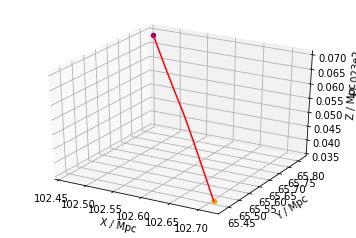

In [443]:
#Note: My personal testing

import matplotlib.pyplot as pyplot

init, fin = [102.71537, 65.430832, 102.336548], [102.46154, 65.814896, 102.368958]
initv, finv = [756.42688, -1104.071655, -121.157196], [716.478271, -1081.993042, -89.589539]

times, pos, vel, redshifts = time_spaced_interpolation_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2], 
                                                               fin[0],fin[1],fin[2],finv[0],finv[1],finv[2], 
                                                               0.279802, 0.319703, return_redshifts=True)

print "redfhits: ", redshifts
print ""
print "age of universe (Gyr): ", times

#pyplot.figure()
#pyplot.scatter(pos[:,0], pos[:,1], c="red")
#pyplot.scatter(pos[0,0], pos[0,1], c="orange")
#pyplot.scatter(pos[-1,0], pos[-1,1], c="purple")
#pyplot.show()

from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos[:,0], pos[:,1], pos[:,2], c="red")
ax.scatter(pos[0,0], pos[0,1], pos[0,2], c="orange")
ax.scatter(pos[-1,0], pos[-1,1], pos[-1,2], c="purple")

ax.set_xlabel('X / Mpc')
ax.set_ylabel('Y / Mpc')
ax.set_zlabel('Z / Mpc')

pyplot.show()


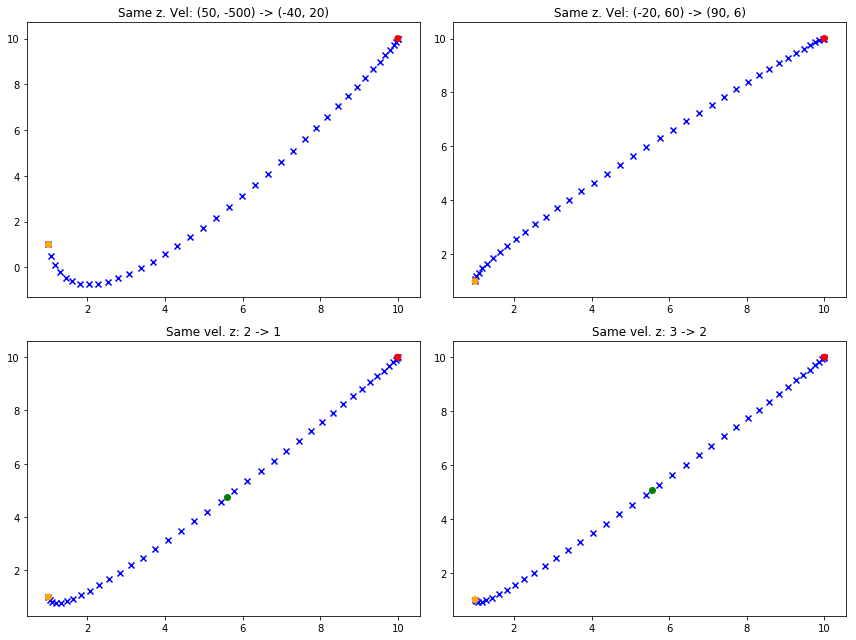

In [455]:
import matplotlib.pyplot as pyplot
smpls = 40


init, fin = [1,1,0], [10,10,0]
initv, finv = [50, -500, 0], [-40, 20, 0]

times, pos, vel = time_spaced_interpolation_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],5,1,samples=smpls) 

#print pos

#print vel

fig = pyplot.figure(figsize=(12,9))

pyplot.subplot(221)
pyplot.title("Same z. Vel: (50, -500) -> (-40, 20)")
pyplot.scatter(pos[:,0], pos[:,1], c="blue", marker="x")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], c=["orange", "red"])
#pyplot.xlim([-2, 12])
#pyplot.ylim([-12,12])




init, fin = [1,1,0], [10,10,0]
initv, finv = [-20, 60, 0], [90, 6,0]

times, pos, vel = time_spaced_interpolation_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],5,1,samples=smpls) 

#print pos

#print vel


pyplot.subplot(222)
pyplot.title("Same z. Vel: (-20, 60) -> (90, 6)")
pyplot.scatter(pos[:,0], pos[:,1], c="blue", marker="x")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], c=["orange", "red"])
#pyplot.xlim([-2, 12])
#pyplot.ylim([-12,12])




init, fin = [1,1,0], [10,10,0]
initv, finv = [50, -500, 0], [-40, 20, 0]

times, pos, vel = time_spaced_interpolation_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],2,1,samples=smpls) 

midtime_z =  apcos.z_at_value(cosmo.age, cosmo.age(2) + (cosmo.age(1) - cosmo.age(2))/2)

st, sp, sv = interpolate_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],2,1,midtime_z)

pyplot.subplot(223)
pyplot.title("Same vel. z: 2 -> 1")
pyplot.scatter(pos[:,0], pos[:,1], c="blue", marker="x")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], c=["orange", "red"])
pyplot.scatter(sp[0], sp[1], c="green")
#pyplot.xlim([-2, 12])
#pyplot.ylim([-12,12])







init, fin = [1,1,0], [10,10,0]
initv, finv = [50, -500, 0], [-40, 20, 0]

times, pos, vel = time_spaced_interpolation_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],3,2,samples=smpls) #,np.linspace(2,3,30))

midtime_z =  apcos.z_at_value(cosmo.age, cosmo.age(3) + (cosmo.age(2) - cosmo.age(3))/2)

st, sp, sv = interpolate_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],3,2,midtime_z)

pyplot.subplot(224)
pyplot.title("Same vel. z: 3 -> 2")
pyplot.scatter(pos[:,0], pos[:,1], c="blue", marker="x")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], c=["orange", "red"])
pyplot.scatter(sp[0], sp[1], c="green")
#pyplot.xlim([-2, 12])
#pyplot.ylim([-12,12])

fig.tight_layout()

pyplot.show()

#pyplot.figure()
#pyplot.plot(times, np.linalg.norm(vel,axis=1))
#pyplot.show()
